<a href="https://colab.research.google.com/github/dashstander/sn-grok/blob/main/Sn_Circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up


In [ ]:
! pip3 install numpy transformer_lens
! pip3 install git+https://github.com/dashstander/sn-grok.git
! gdown https://drive.google.com/drive/folders/1gcTiyX8zymnLdUtOceXotS3-o5toPEJX?usp=sharing --folder

## Introduction to Permutations

The code to work with the symmetric group $S_n$ of permutations on $n$ objects in in `sngrok.permutations`. Permutations are given as zero indexed tuples in 1-line notation. You start with two-line notation, such as:

$$ \sigma = \begin{pmatrix} 0 && 1 && 2 && 3 && 4 \\ 1 && 3 && 0 && 4 && 2\end{pmatrix}$$

Which represents the following map:

$$ \begin{align} \sigma(0) ↦ 1 \\ \sigma(1) ↦ 3 \\ \sigma(2) ↦ 0 \\ \sigma(4) ↦ 2 \\ \end{align} $$

which is to say two-line notation shows how the identity permutation is mapped to $\sigma$. Since the identity is implicit, one-line notation just drops it:

$$ \sigma = \begin{pmatrix} 1 && 3 && 0 && 4 && 2\end{pmatrix}$$

You compose matrices by first applying one then the other.

In [5]:
from sngrok.permutations import Permutation
from sngrok.groups import generate_subgroup


# Permutations are zero-indexed, given in 1-line notation
ident = Permutation((0, 1, 2, 3, 4))
transpose01 = Permutation((1, 0, 2, 3, 4))
transpose34 = Permutation((0, 1, 2, 4, 3))
five_cycle = Permutation((1, 3, 0, 4, 2))

print("Disjoint cycles commute")
print(f'{transpose01} * {transpose34} == {transpose01 * transpose34}')
assert transpose01 * transpose34 == transpose34 * transpose01
print("But in general the products don't commute")
print(f'{five_cycle} * {transpose34} == {five_cycle * transpose34}')
print(f'{transpose34} * {five_cycle} == {transpose34 * five_cycle}')


Disjoint cycles commute
(1, 0, 2, 3, 4) * (0, 1, 2, 4, 3) == (1, 0, 2, 4, 3)
But in general the products don't commute
(1, 3, 0, 4, 2) * (0, 1, 2, 4, 3) == (1, 4, 0, 3, 2)
(0, 1, 2, 4, 3) * (1, 3, 0, 4, 2) == (1, 3, 0, 2, 4)


In [6]:
# Can easily get the order of a permutation
print(five_cycle.order)
# And can use exponent notation
print([five_cycle ** i for i in range(1, five_cycle.order + 1)])

5
[(1, 3, 0, 4, 2), (3, 4, 1, 2, 0), (4, 2, 3, 0, 1), (2, 0, 4, 1, 3), (0, 1, 2, 3, 4)]


In [7]:
# Can also get the cycle representation
print(f'{transpose34} --> {transpose34.cycle_rep}')
print(f'{five_cycle} --> {five_cycle.cycle_rep}')

(0, 1, 2, 4, 3) --> [(3, 4), (2,), (1,), (0,)]
(1, 3, 0, 4, 2) --> [(0, 2, 4, 3, 1)]


### Subgroups and Cosets

In [8]:
from itertools import islice
# generate a subgroup of a symmetric group with a set of generators

def batched(iterable, n):
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

# This is the copy of S_4 in S_5 that fixes 0 in the 0th place
# Products of (0, 2, 3, 4, 1) and (0, 2, 1, 3, 4) (and their inverses) generate all of S_4
# See e.g. https://groupprops.subwiki.org/wiki/Symmetric_group:S5#Table_classifying_subgroups_up_to_automorphisms
# for info on subgroups and generators
fixes_0 = generate_subgroup([(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)])
for batch in batched(fixes_0, 4):
    print('\t'.join([str(perm) for perm in batch]))


(0, 1, 3, 4, 2)	(0, 2, 1, 3, 4)	(0, 4, 2, 3, 1)	(0, 4, 3, 2, 1)
(0, 2, 3, 4, 1)	(0, 2, 4, 3, 1)	(0, 1, 3, 2, 4)	(0, 4, 2, 1, 3)
(0, 4, 3, 1, 2)	(0, 3, 2, 4, 1)	(0, 2, 4, 1, 3)	(0, 3, 1, 4, 2)
(0, 3, 4, 2, 1)	(0, 3, 4, 1, 2)	(0, 2, 3, 1, 4)	(0, 1, 4, 3, 2)
(0, 3, 1, 2, 4)	(0, 4, 1, 3, 2)	(0, 1, 2, 4, 3)	(0, 4, 1, 2, 3)
(0, 1, 4, 2, 3)	(0, 3, 2, 1, 4)	(0, 2, 1, 4, 3)	(0, 1, 2, 3, 4)


In [9]:
from itertools import product

# The code for generating a subgroup is really dumb.
def _generate_subgroup(generators: list[tuple[int]]):
    group_size = 0
    # You start with the set of generators that you're given (as a list of permutation tuples)
    all_perms = set(generators)
    while group_size < len(all_perms):
        # The loop stops when all of the multiplications happen and no new permutations appear
        # i.e. we have a subgroup that's closed under multiplication.
        # May still output the entire group
        group_size = len(all_perms)
        perms = [Permutation(p) for p in all_perms]
        for perm1, perm2 in product(perms, repeat=2):
            perm3 = perm1 * perm2
            # all_perms is a set, so handles duplicates
            # perm3.sigma returns the underlying tuple from the permutation
            all_perms.add(perm3.sigma)
    return list(all_perms)

In [10]:
from functools import reduce

def union(cosets):
    """Helper function to take the full union of a list of sets
    """
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)


def get_left_cosets(subgroup, n):
    """ Quick and dirt way to calculate left cosets
    """
    # All `n!` elements of Sn
    Sn =  Permutation.full_group(n)
    # Keep track of the whole thing as a set.
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    # We know we're done when the union of all of the cosets covers all of Sn
    while union(cosets) != all_sn:
        left = Sn.pop()
        # Translate the subgroup by an element of Sn we haven't used yet
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        # So a set of tuples of tuples
        cosets.add(coset)
    return cosets


def get_right_cosets(subgroup, n):
    """ Quick and dirt way to calculate right cosets
    Same as above, with
    """
    Sn =  Permutation.full_group(n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        # See, now we're just multiplying our element on the _right_
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets


In [11]:
lcos = get_left_cosets(fixes_0, 5)
print("All of the left cosets. They are organized by what index 0 is in")
for coset in lcos:
    print('##################################\n##################################')
    for batch in batched(coset, 4):
        print('\t'.join([str(perm) for perm in batch]))

All of the left cosets. They are organized by what index 0 is in
##################################
##################################
(1, 2, 3, 0, 4)	(1, 2, 4, 0, 3)	(1, 3, 2, 0, 4)	(1, 3, 4, 0, 2)
(1, 4, 2, 0, 3)	(1, 4, 3, 0, 2)	(2, 1, 3, 0, 4)	(2, 1, 4, 0, 3)
(2, 3, 1, 0, 4)	(2, 3, 4, 0, 1)	(2, 4, 1, 0, 3)	(2, 4, 3, 0, 1)
(3, 1, 2, 0, 4)	(3, 1, 4, 0, 2)	(3, 2, 1, 0, 4)	(3, 2, 4, 0, 1)
(3, 4, 1, 0, 2)	(3, 4, 2, 0, 1)	(4, 1, 2, 0, 3)	(4, 1, 3, 0, 2)
(4, 2, 1, 0, 3)	(4, 2, 3, 0, 1)	(4, 3, 1, 0, 2)	(4, 3, 2, 0, 1)
##################################
##################################
(1, 2, 0, 3, 4)	(1, 2, 0, 4, 3)	(1, 3, 0, 2, 4)	(1, 3, 0, 4, 2)
(1, 4, 0, 2, 3)	(1, 4, 0, 3, 2)	(2, 1, 0, 3, 4)	(2, 1, 0, 4, 3)
(2, 3, 0, 1, 4)	(2, 3, 0, 4, 1)	(2, 4, 0, 1, 3)	(2, 4, 0, 3, 1)
(3, 1, 0, 2, 4)	(3, 1, 0, 4, 2)	(3, 2, 0, 1, 4)	(3, 2, 0, 4, 1)
(3, 4, 0, 1, 2)	(3, 4, 0, 2, 1)	(4, 1, 0, 2, 3)	(4, 1, 0, 3, 2)
(4, 2, 0, 1, 3)	(4, 2, 0, 3, 1)	(4, 3, 0, 1, 2)	(4, 3, 0, 2, 1)
###########################

In [12]:
rcos = get_right_cosets(fixes_0, 5)
print("All of the right cosets. They are organized by what number is in the 0th position")
for coset in rcos:
    print('##################################\n##################################')
    for batch in batched(coset, 4):
        print('\t'.join([str(perm) for perm in batch]))

All of the right cosets. They are organized by what number is in the 0th position
##################################
##################################
(3, 0, 1, 2, 4)	(3, 0, 1, 4, 2)	(3, 0, 2, 1, 4)	(3, 0, 2, 4, 1)
(3, 0, 4, 1, 2)	(3, 0, 4, 2, 1)	(3, 1, 0, 2, 4)	(3, 1, 0, 4, 2)
(3, 1, 2, 0, 4)	(3, 1, 2, 4, 0)	(3, 1, 4, 0, 2)	(3, 1, 4, 2, 0)
(3, 2, 0, 1, 4)	(3, 2, 0, 4, 1)	(3, 2, 1, 0, 4)	(3, 2, 1, 4, 0)
(3, 2, 4, 0, 1)	(3, 2, 4, 1, 0)	(3, 4, 0, 1, 2)	(3, 4, 0, 2, 1)
(3, 4, 1, 0, 2)	(3, 4, 1, 2, 0)	(3, 4, 2, 0, 1)	(3, 4, 2, 1, 0)
##################################
##################################
(2, 0, 1, 3, 4)	(2, 0, 1, 4, 3)	(2, 0, 3, 1, 4)	(2, 0, 3, 4, 1)
(2, 0, 4, 1, 3)	(2, 0, 4, 3, 1)	(2, 1, 0, 3, 4)	(2, 1, 0, 4, 3)
(2, 1, 3, 0, 4)	(2, 1, 3, 4, 0)	(2, 1, 4, 0, 3)	(2, 1, 4, 3, 0)
(2, 3, 0, 1, 4)	(2, 3, 0, 4, 1)	(2, 3, 1, 0, 4)	(2, 3, 1, 4, 0)
(2, 3, 4, 0, 1)	(2, 3, 4, 1, 0)	(2, 4, 0, 1, 3)	(2, 4, 0, 3, 1)
(2, 4, 1, 0, 3)	(2, 4, 1, 3, 0)	(2, 4, 3, 0, 1)	(2, 4, 3, 1, 0)
##########

## Fourier Analysis

Refer to [chapters 1 and 2 or Risi Kondor's thesis](https://people.cs.uchicago.edu/~risi/papers/KondorThesis.pdf) or to [this monograph by Persi Diaconis](https://jdc.math.uwo.ca/M9140a-2012-summer/Diaconis.pdf) for a more thorough treatment of Fourier analysis on groups.


For our purposes, the necessary code is in `sngrok.irreps` and `sngrok.fourier`.

Consider a function $f: S_{3} \rightarrow \mathbb{R}$, like this:

$$\begin{align}
f( (0, 1, 2)) &= 2.5 \\
f( (1, 2, 0)) &= 0.5 \\
f( (2, 0, 1)) &= 0 \\
f( (0, 2, 1)) &= 1 \\
f( (1, 0, 2)) &= 3.5 \\
f( (2, 1, 0)) &= 4 \\
\end{align}$$

In [13]:
import numpy as np

# In the code we just represent a function like that as an array
f = np.array([2.5, 0.5, 0, 1, 3.5, 4])

### Irreducible Representations

In [14]:
from sngrok.irreps import SnIrrep

# The irreducible representations of Sn are indexed by the number of partitions of n
# For S3, that is, (1, 1, 1), (3,), and (2, 1)

# All ones is always the trivial representation
irrep111 = SnIrrep(3, (1, 1, 1)).matrix_representations()

# The irreps are stored as a dictionary with permutation (tuple) keys and numpy /
# torch matrix values
# The trivial representation is just ones
for perm, irrep in irrep111.items():
    print(perm)
    print(irrep)
    print('#############')

(1, 0, 2)
[[-1.]]
#############
(0, 2, 1)
[[-1.]]
#############
(2, 1, 0)
[[-1.]]
#############
(0, 1, 2)
[[1.]]
#############
(1, 2, 0)
[[1.]]
#############
(2, 0, 1)
[[1.]]
#############


In [15]:
# the (n,) irrep is the _alternating_ representation
# Even permutations get 1.0 and odd permutations get -1
irrep3 = SnIrrep(3, (3,)).matrix_representations()
for perm, irrep in irrep3.items():
    print(perm)
    print(irrep)
    print('#############')

(1, 0, 2)
[[1.]]
#############
(0, 2, 1)
[[1.]]
#############
(2, 1, 0)
[[1.]]
#############
(0, 1, 2)
[[1.]]
#############
(1, 2, 0)
[[1.]]
#############
(2, 0, 1)
[[1.]]
#############


In [16]:
# The other irreps are where things get interesting
# The only other irrep for S3 is (2, 1)
irrep21 = SnIrrep(3, (2, 1)).matrix_representations()
for perm, irrep in irrep21.items():
    print(perm)
    print(irrep)
    print('#############')

(1, 0, 2)
[[ 1.  0.]
 [ 0. -1.]]
#############
(0, 2, 1)
[[-0.5        0.8660254]
 [ 0.8660254  0.5      ]]
#############
(2, 1, 0)
[[-0.5       -0.8660254]
 [-0.8660254  0.5      ]]
#############
(0, 1, 2)
[[1. 0.]
 [0. 1.]]
#############
(1, 2, 0)
[[-0.5       -0.8660254]
 [ 0.8660254 -0.5      ]]
#############
(2, 0, 1)
[[-0.5        0.8660254]
 [-0.8660254 -0.5      ]]
#############


In [17]:
# But you can check that matrix multplication of the irreps corresponds to group multiplication
S3 = Permutation.full_group(3)
for perm1, perm2 in product(S3, S3):
    # group mult
    perm_prod = perm1 * perm2
    # again, using perm.sigma to get the underlying tuple
    mat1 = irrep21[perm1.sigma]
    mat2 = irrep21[perm2.sigma]
    # corresponding matrix multiplication
    mat_prod = mat1 @ mat2
    assert np.allclose(irrep21[perm_prod.sigma], mat_prod)


### Fourier Transform

The Fourier transform on $S_{n}$ take a function $f: S_n \rightarrow \mathbb{R}$ and returns a new function $\hat{f}$ that maps _irreducible representations_ of $S_{n}$ to $\mathbb{R}$

In [20]:
import torch
from sngrok.fourier import slow_sn_ft_1d, calc_power

# the "1_d" refers to it being one copy of Sn, i.e. a function from Sn -> R as
# opposed to (Sn, Sn) -> R
# shitty name, I know


# Oh also the fourier transform code only works on torch tensors now :/
f_original = torch.asarray(f, dtype=torch.float32).unsqueeze(1)

# slow_ft takes an array of the function values and returns a dict, with tuple
# keys that correspond to irreps (recall: partitions) and matrix values
f_hat = slow_sn_ft_1d(f_original, 3)

In [21]:
# f_hat of the trivial irrep (1, 1, 1) is always just the sum of values of f

print(f"f_hat((1, 1, 1)) == {f_hat[(1, 1, 1)].item()}")
print(f"sum(f) == {f_original.sum().item()}")

f_hat((1, 1, 1)) == -5.5
sum(f) == 11.5


In [22]:
# f_hat of the alternating irrep (3,) is the difference between f on even and odd perms

even_total = 0.0
odd_total = 0.0
for perm, fval in zip(S3, f.tolist()):
    if perm.parity == 0:
        even_total += fval
    else:
        odd_total += fval

print(f'sum( even perms ) == {even_total}')
print(f'sum( odd perms ) == {odd_total}')
print(f'({even_total} - {odd_total}) == {f_hat[(3,)]}')

sum( even perms ) == 3.0
sum( odd perms ) == 8.5
(3.0 - 8.5) == 11.5


In [23]:
# The other f_hat for all the other irreps is matrix-valued and tougher to interpret
print(f_hat[(2, 1)])

tensor([[ 3.2500, -3.0311],
        [-2.1651,  1.2500]])


## The Model

The model is the same architecture as from ["A Toy Model of Universality"](https://arxiv.org/abs/2302.03025) by Chughtai et al.

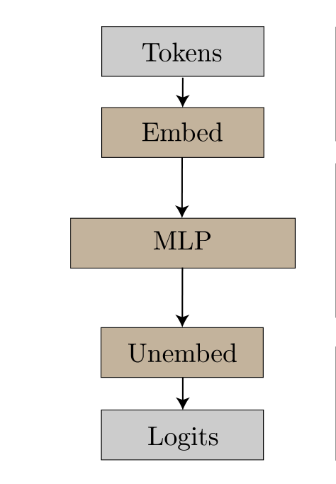

In [ ]:
#! gdown https://drive.google.com/drive/folders/1uLdwJEBqtWloM8T077yFFVTzbI7orVIb?usp=sharing --folder
#! pip3 install git+https://github.com/neelnanda-io/TransformerLens

In [25]:
from pathlib import Path
import polars as pl
from sngrok.model import SnMLP

ckpt_dir = Path('sn-circuits-s5-small/')
seed = 0 # 0 or 127
run_name = f's5_40_{seed}'

run_dir = ckpt_dir / run_name

# `full_run.pth` has most of the run info you might want
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))

# This data has all of the permutations as long as what was in the train vs test for this run
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

out, cache = model.run_with_cache(lperms, rperms)
#loss = loss_fn(out, targets)

linear_acts = cache['hook_linear']

In [27]:
# I use plotnine because I learned ggplot early in my career. Feel free to use
# whatever libraries you're most comfortable with
from plotnine import (
    ggplot,
    aes,
    theme,
    element_text,
    stat_smooth,
    facet_wrap,
    geom_boxplot,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse
)
import math
from sngrok.fourier import calc_power


def calc_power_contributions(tensor, n):
    """Calculates how much each irrep contributes to the norm of the dimension, and returns it
    as a polars dataframe.
    """
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    tensor_dim = tensor.shape[1]
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(tensor_dim)])
    val_data.insert_column(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


# If the left embedding is a [num_perm, embed_dim] matrix, then each column of
# the matrix has 120 elements and can be though of as a a function from S_5 to R
# The fourier transform is over each of those functions
lembed_power_df, lembed_ft = calc_power_contributions(model.lembed.weight, 5)
rembed_power_df, rembed_ft = calc_power_contributions(model.rembed.weight, 5)


In [28]:
# Polars data frame because I kinda hate pandas, sorry
# https://pola-rs.github.io/polars/py-polars/html/reference/index.html
lembed_power_df.head()

irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,…,dim219,dim220,dim221,dim222,dim223,dim224,dim225,dim226,dim227,dim228,dim229,dim230,dim231,dim232,dim233,dim234,dim235,dim236,dim237,dim238,dim239,dim240,dim241,dim242,dim243,dim244,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(1, 1, 1, 1, 1…",0.083399,0.098733,0.093341,0.081777,0.088074,0.105021,0.09499,0.083377,0.081778,0.085713,0.080905,0.094988,0.088069,0.09176,0.088235,0.081779,0.081777,0.085713,0.093012,0.083377,0.105014,0.081779,0.087887,0.092545,0.081781,0.088235,0.091495,0.105016,0.105013,0.092545,0.088234,0.095615,0.093717,0.09176,0.093717,0.087887,…,0.091495,0.083425,0.098733,0.092612,0.112728,0.088094,0.088235,0.081779,0.09176,0.086973,0.093717,0.083436,0.087887,0.085713,0.081779,0.088235,0.091761,0.087888,0.092539,0.093717,0.086973,0.080905,0.088216,0.098951,0.095614,0.088043,0.083377,0.094994,0.085713,0.080912,0.098733,0.088235,0.080907,0.083398,0.091495,0.083377,0.092544
"""(2, 1, 1, 1)""",0.000038,0.000069,0.000084,0.000039,0.000033,0.000069,0.000042,0.000073,0.000039,0.000046,0.000046,0.000042,0.000033,0.000076,0.000048,0.000039,0.000039,0.000046,0.000064,0.000073,0.000069,0.000039,0.000075,0.000067,0.000039,0.000048,0.000041,0.000069,0.000069,0.000067,0.000048,0.000073,0.000045,0.000076,0.000045,0.000075,…,0.000041,0.000038,0.000069,0.000067,0.000097,0.000033,0.000048,0.000039,0.000076,0.00007,0.000045,0.000038,0.000075,0.000046,0.000039,0.000048,0.000076,0.000075,0.000067,0.000045,0.00007,0.000046,0.000033,0.000033,0.000073,0.000033,0.000073,0.000042,0.000046,0.000046,0.000069,0.000048,0.000046,0.000038,0.000041,0.000073,0.000067
"""(2, 2, 1)""",0.002013,0.002261,0.002131,0.001682,0.00161,0.001839,0.002119,0.00172,0.001682,0.001551,0.001864,0.002119,0.00161,0.002005,0.001811,0.001682,0.001682,0.001551,0.001872,0.00172,0.001839,0.001682,0.002186,0.001983,0.001682,0.001811,0.00207,0.001839,0.001839,0.001983,0.001811,0.002054,0.001665,0.002005,0.001665,0.002186,…,0.00207,0.002013,0.002261,0.001983,0.002581,0.001611,0.001811,0.001682,0.002005,0.001727,0.001665,0.002014,0.002186,0.001551,0.001682,0.001811,0.002005,0.002186,0.001983,0.001665,0.001727,0.001864,0.001614,0.002106,0.002054,0.001609,0.00172,0.002119,0.001551,0.001864,0.002261,0.001811,0.001864,0.002013,0.00207,0.00172,0.001983
"""(3, 1, 1)""",0.000012,0.000015,0.00002,0.00002,0.000007,0.000018,0.000013,0.000013,0.00002,0.000011,0.000014,0.000013,0.000007,0.000011,0.000015,0.00002,0.00002,0.000011,0.000012,0.000013,0.000018,0.00002,0.000016,0.000011,0.00002,0.000015,0.000009,0.000018,0.000018,0.000011,0.000015,0.000013,0.000015,0.000011,0.000015,0.000016,…,0.000009,0.000012,0.000015,0.000011,0.000007,0.000007,0.000015,0.00002,0.000011,0.000013,0.000015,0.000012,0.000016,0.000011,0.00002,0.000015,0.000011,0.000016,0.000011,0.000015,0.000013,0.000014,0.000007,0.000025,0.000013,0.000007,0.000013,0.000013,0.000011,0.000014,0.000015,0.000015,0.000014,0.000012,0.000009,0.000013,0.000011
"""(3, 2)""",0.004657,0.004185,0.004196,0.004074,0.00436,0.003819,0.004309,0.004437,0.004074,0.003981,0.004287,0.004309,0.00436,0.004816,0.004546,0.004074,0.004074,0.003981,0.004714,0.004437,0.003819,0.004074,0.004688,0.004151,0.004074,0.004546,0.004267,0.003819,0.003819,0.004151,0.004546,0.004924,0.004074,0.004816,0.004074,0.004688,…,0.004267,0.004656,0.004185,0.004149,0.004336,0.004361,0.004546,0.004074,0.004816,0.00428,0.004074,0.004656,0.004688,0.003981,0.004074,0.004546,0.004816,0.004688,0.004152,0.004074,0.00428,0.004287,0.004361,0.00

In [29]:
# Should be considered as percentages
lembed_power_df.select(['irrep', 'dim0'])

irrep,dim0
str,f32
"""(1, 1, 1, 1, 1…",0.083399
"""(2, 1, 1, 1)""",0.000038
"""(2, 2, 1)""",0.002013
"""(3, 1, 1)""",0.000012
"""(3, 2)""",0.004657
"""(4, 1)""",0.90988
"""(5,)""",1.0971e-7


In [30]:
# dataframe.melt changes the data from "wide" (one column per dim) to "long" format
# (one row per irrep per dim, with the dim info in a column called `variable` and the
# percentages in `value` )
# In general the plotting and often analysis are easier when the data is in
# "tidy" / "long" format, see: https://www.jstatsoft.org/article/view/v059i10
# Will do this a lot so just a peak at what it looks like:
lembed_power_df.filter(pl.col("irrep") != "(1, 1, 1, 1, 1)").melt(id_vars="irrep").head(14)

irrep,variable,value
str,str,f32
"""(2, 1, 1, 1)""","""dim0""",0.000038
"""(2, 2, 1)""","""dim0""",0.002013
"""(3, 1, 1)""","""dim0""",0.000012
"""(3, 2)""","""dim0""",0.004657
"""(4, 1)""","""dim0""",0.90988
"""(5,)""","""dim0""",1.0971e-7
"""(2, 1, 1, 1)""","""dim1""",0.000069
"""(2, 2, 1)""","""dim1""",0.002261
"""(3, 1, 1)""","""dim1""",0.000015


As you can see, for, this run the `(2, 1, 1, 1)` irrep dominated. We filter out the `(5,)` irrep because it's very close to 0 and doesn't contribute anything


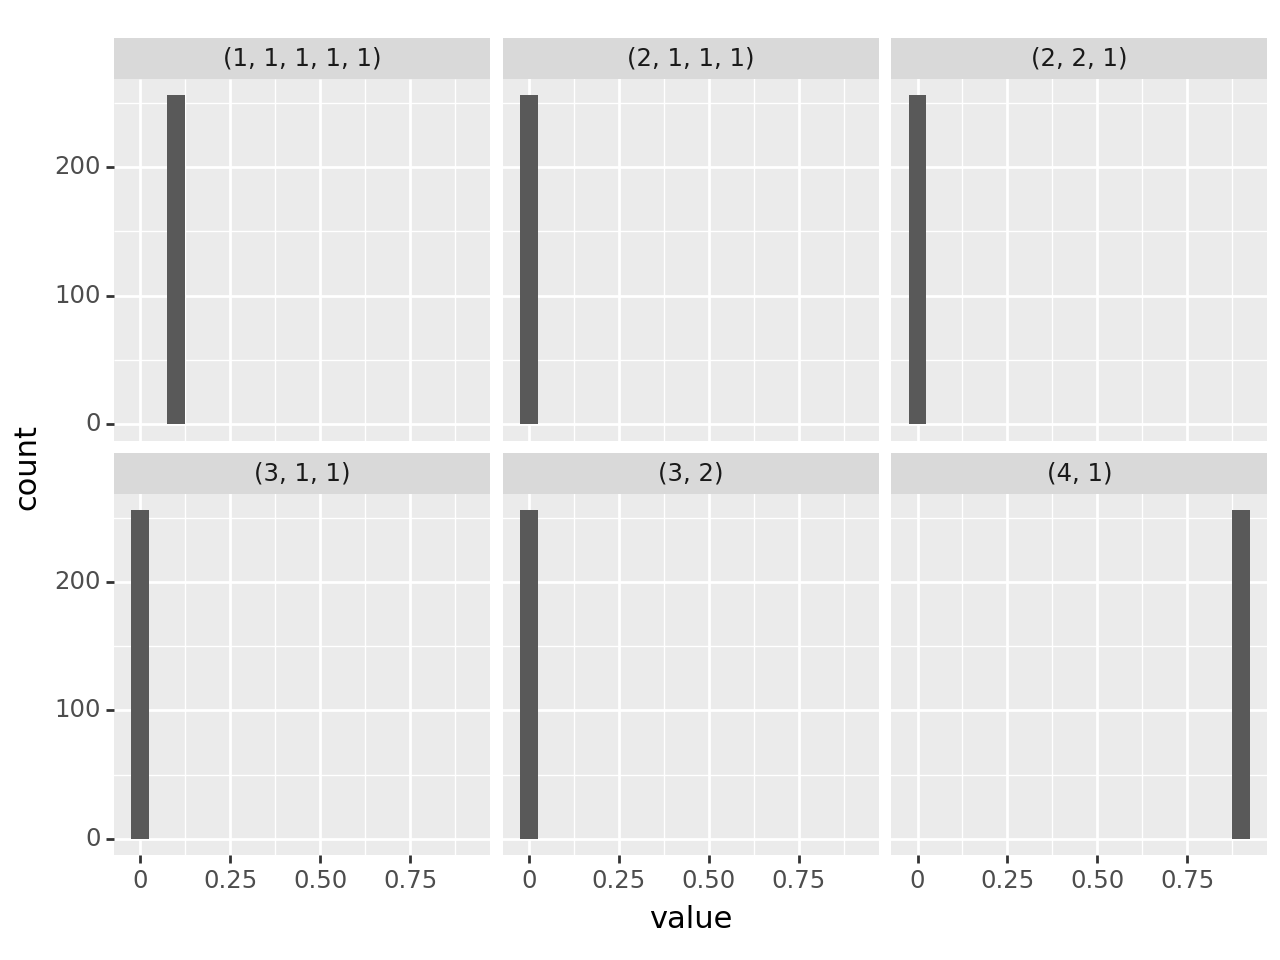

<Figure Size: (640 x 480)>

In [32]:

ggplot(
    lembed_power_df.filter(pl.col("irrep") != "(5,)").melt(id_vars="irrep"),
    aes(x="value")
) + geom_histogram(binwidth=0.05) + facet_wrap("~irrep")

The right embedding is largely similar.

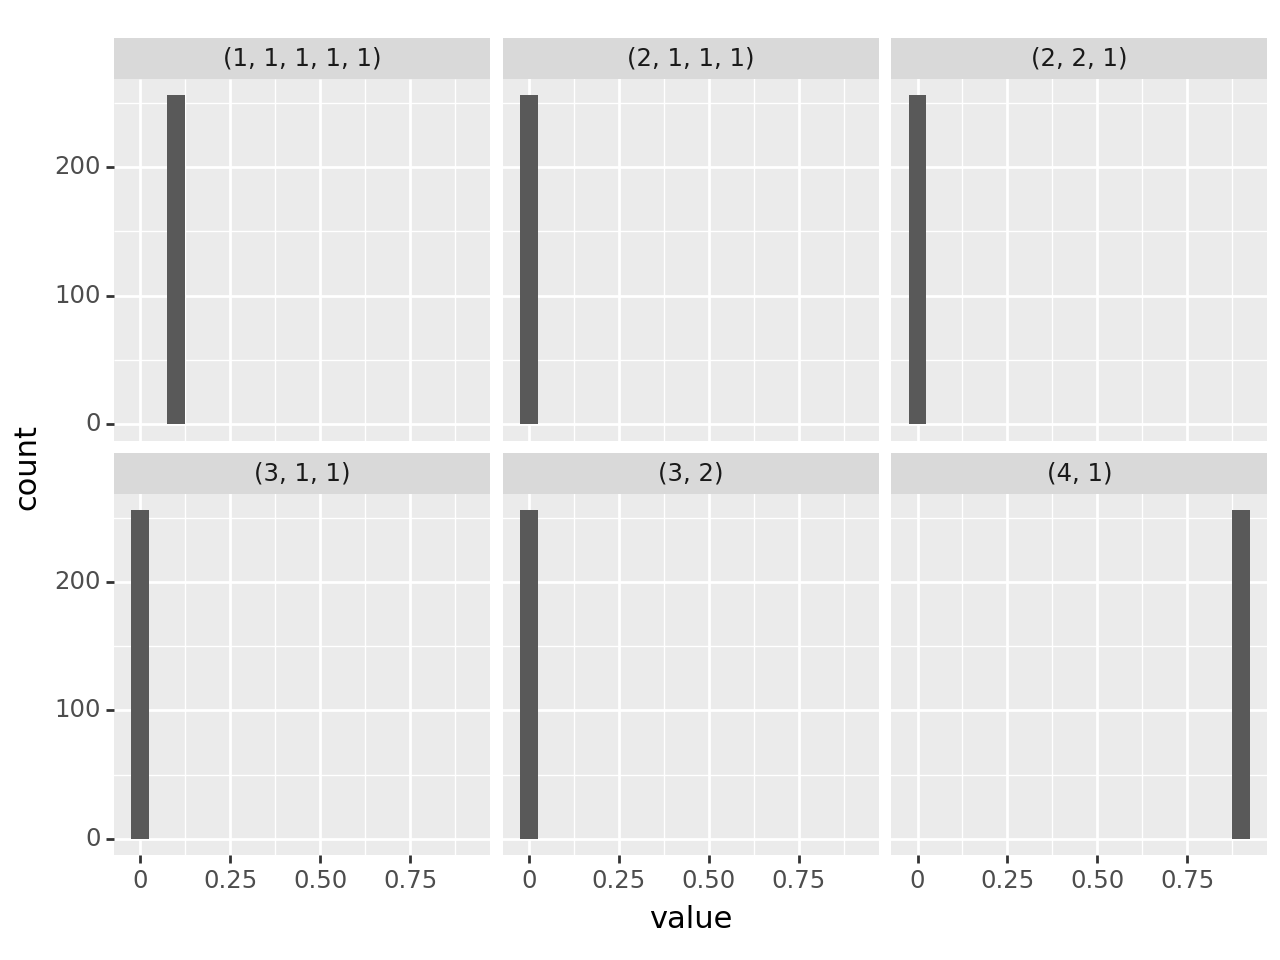

<Figure Size: (640 x 480)>

In [33]:

ggplot(
    rembed_power_df.filter(pl.col("irrep") != "(5,)").melt(id_vars="irrep"),
    aes(x="value")
) + geom_histogram(binwidth=0.05) + facet_wrap("~irrep")

The first layer is calculated as `W @ concat([left_embed, right_embed])`. There's no nonlinearity, so this is the precise same as `(W[:, :embed_dim] @ left_embed) + (W[:, embed_dim:] @ right_embed)`, i.e. just splitting up the columns of the weight matrix `W` into left and right halves and then adding them together. We can also these activations.

In [34]:
W = model.linear.weight

lact_power_df, lact_ft = calc_power_contributions(model.lembed.weight @ W[:, :256].T, 5)
ract_power_df, ract_ft = calc_power_contributions(model.rembed.weight @ W[:, 256:].T, 5)

 Still dominated by (2, 1, 1, 1) but there _are_ dimensions of the linear layer that use (2, 2, 1), (3, 2), (4, 1), and (5,)

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 18 rows containing non-finite values.


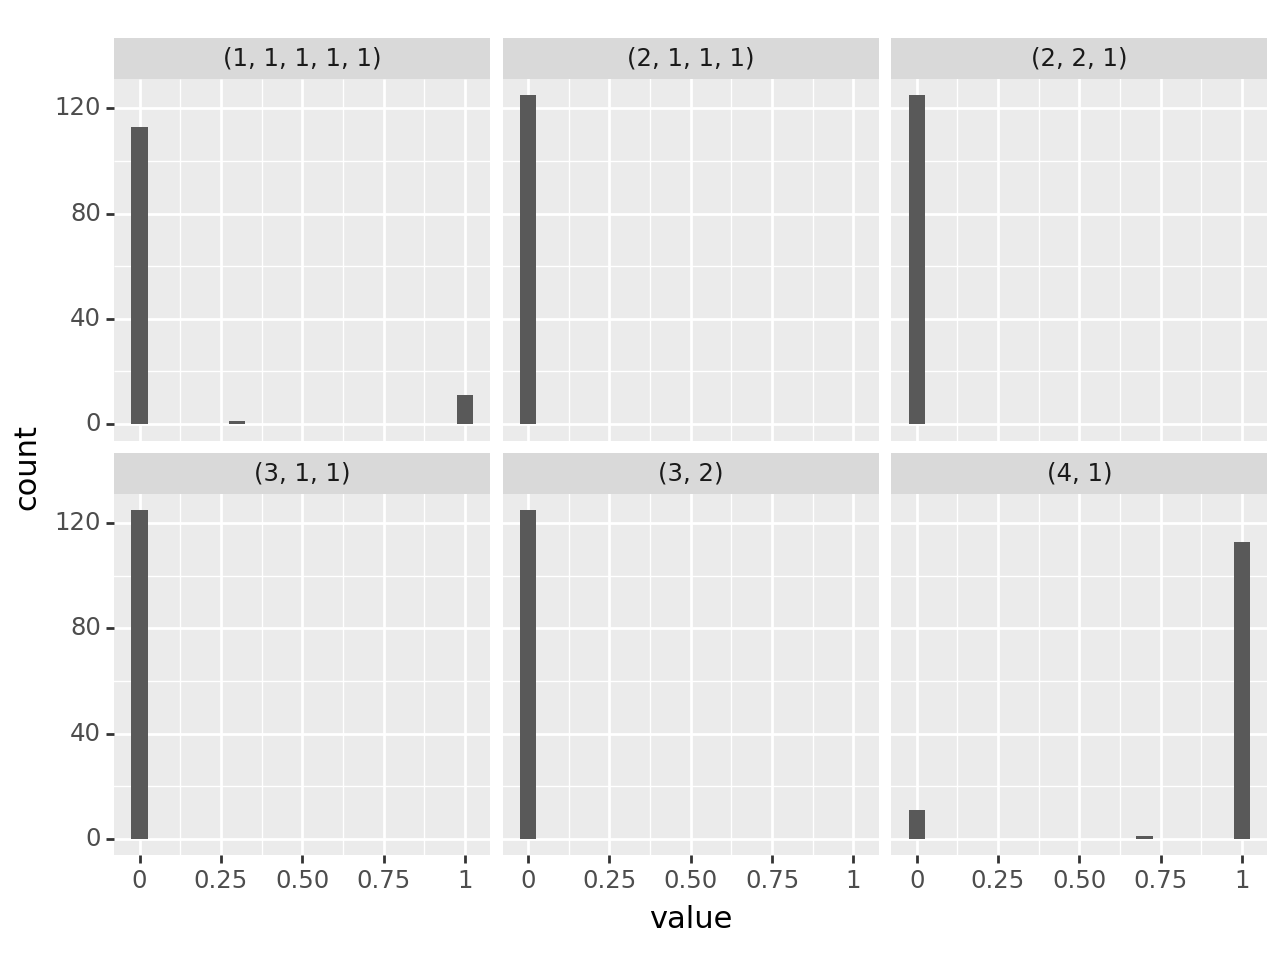

<Figure Size: (640 x 480)>

In [35]:

ggplot(
    lact_power_df.filter(pl.col("irrep") != "(5,)").melt(id_vars="irrep"),
    aes(x="value")
) + geom_histogram(binwidth=0.05) + facet_wrap("~irrep")

Again, largely similar on the right.


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 18 rows containing non-finite values.


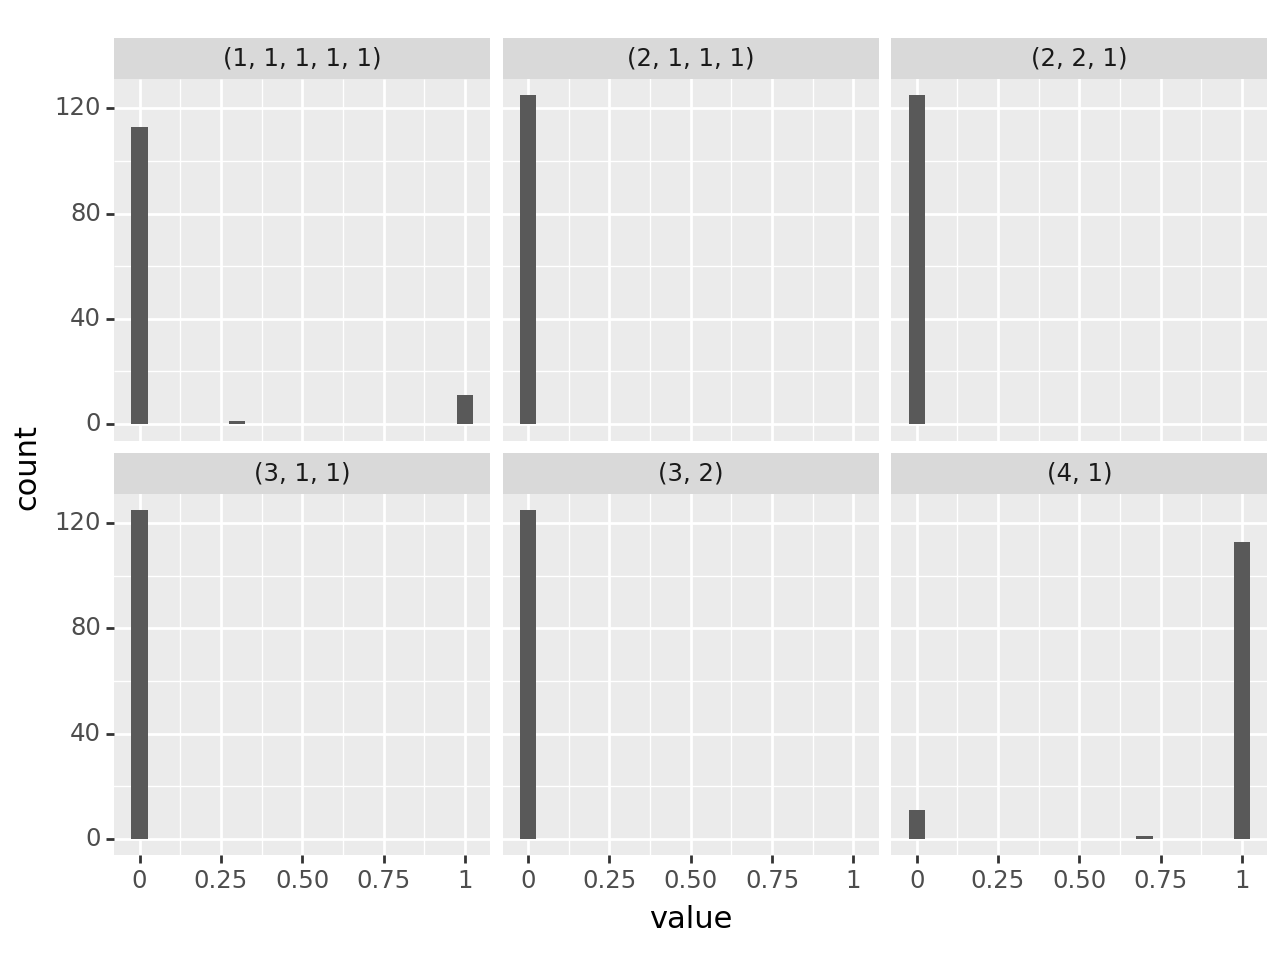

<Figure Size: (640 x 480)>

In [36]:
ggplot(
    ract_power_df.filter(pl.col("irrep") != "(5,)").melt(id_vars="irrep"),
    aes(x="value")
) + geom_histogram(binwidth=0.05) + facet_wrap("~irrep")

The way that the "fourier basis" works is that it we can get $f$ back from the Fourier-transformed $\hat{f}$. For a permutation $\sigma \in S_{5}$ :

$$ f(\sigma) =\frac{1}{|S_{5}|}\sum_{\rho \in \mathcal{R}} d_{\rho}\operatorname{tr}[\hat{f}(\rho)\rho(\sigma^{-1})] $$

where each $\rho \in \mathcal{R}$ is one of the irreps, i.e. one of `(1, 1, 1, 1, 1)`, `(2, 1, 1, 1)`, `(2, 2, 1)`, `(3, 1, 1)`, `(3, 2)`, `(4, 1)`, or `(5,)`.

In the above equation, $\hat{f}(\rho)\rho(\sigma^{-1})$ is given by matrix multiplication and $d_{\rho}$ is the dimension of the representation $\rho$.

So we can get the exact same function back as a unique sum in terms of the Fourier transform. If we just stop short of "reducing" the final sum, then we can break down $f$ into components corresponding to the irreps, and treat this as a 7D basis for our function, like so:
$$ \frac{1}{120} \begin{pmatrix} \hat{f}(\rho_{triv}) \\ sgn(\sigma)\hat{f}(\rho_{alt}) \\ 4 \cdot \operatorname{tr}[\hat{f}(\rho_{(4, 1)})\rho_{(4, 1)}(\sigma^{-1})] \\ 5 \cdot \operatorname{tr}[\hat{f}(\rho_{(3, 2)})\rho_{(3, 2)}(\sigma^{-1})] \\ 6 \cdot \operatorname{tr}[\hat{f}(\rho_{(3, 1, 1)})\rho_{(3, 1, 1)}(\sigma^{-1})] \\ 5 \cdot \operatorname{tr}[\hat{f}(\rho_{(2, 2, 1)})\rho_{(2, 2, 1)}(\sigma^{-1})] \\ 4 \cdot \operatorname{tr}[\hat{f}(\rho_{(2, 1, 1, 1)})\rho_{(2, 1, 1, 1)}(\sigma^{-1})] \end{pmatrix}$$

That's what the function `sn_fourier_basis` calculates

In [40]:
from sngrok.fourier import sn_fourier_basis
from sngrok.tableau import generate_partitions
from sngrok.groups import Symmetric


def fourier_basis_to_df(tensor, n):
    # Takes an inverse Fourier transform tensor and makes a dataframe
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps

    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


S5 = Symmetric(5)

lact_fourier_basis = sn_fourier_basis(lact_ft, S5)
lact_df = fourier_basis_to_df(lact_fourier_basis, 5)

ract_fourier_basis = sn_fourier_basis(ract_ft, S5)
ract_df = fourier_basis_to_df(ract_fourier_basis, 5)


In [41]:
lact_df.head()

permutation,irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(1, 1, 1, 1, 1…",-2.2692e-9,0.000004,5.7515e-8,-0.000062,0.00003,-2.627137,-0.000017,2.627035,0.000074,-0.000055,-0.000043,-0.000035,-0.204794,-0.000038,0.000041,-0.000036,-2.9288e-20,0.000048,0.000013,0.000045,-0.000031,-0.000029,-1.4199e-17,0.000115,-0.000047,-0.000101,5.9604e-30,-0.000003,-2.0216e-25,-6.3640e-14,0.000056,3.7579e-25,-0.000022,5.2376e-14,0.000014,…,0.000056,-0.000032,-0.000033,-0.000074,0.000025,-0.000043,-0.000021,2.348668,0.000095,0.000014,0.00001,-2.095855,0.000013,-0.000005,-0.000021,-0.000018,-2.095839,-0.000014,-0.000058,-2.095588,-0.000054,2.349152,0.000018,2.349575,0.000003,-0.000048,-0.000036,2.0518e-28,-0.000017,0.000015,0.000011,2.347921,0.000033,0.000041,-8.7298e-23,-0.000012,-1.1468e-26
"""(0, 1, 2, 3, 4…","""(2, 1, 1, 1)""",4.4001e-9,-0.000199,-3.8475e-8,-0.000067,0.000297,0.000047,-0.000252,-0.000025,0.000041,0.000086,0.000148,0.000015,-0.000019,-0.000199,0.000036,-0.000227,-9.1905e-20,0.000056,-0.000247,-0.000137,0.000122,-0.000036,3.2288e-17,-0.000099,-0.000226,-0.000045,1.5142e-30,0.000114,1.4306e-24,-1.6959e-13,0.000296,-2.2274e-25,-0.000045,1.2737e-13,-0.000015,…,0.000348,-0.000082,0.000044,0.000061,-0.000063,0.000091,0.00027,-0.000064,0.000368,0.000185,-0.000247,0.000034,0.00018,-0.000252,0.000339,-0.000037,0.000037,-0.000157,-0.000377,0.000043,-0.000049,-0.000053,0.00012,-0.000061,0.000032,0.000181,-0.000237,-2.4757e-28,-0.000158,0.000196,0.000217,-0.00007,-0.000237,0.00002,-2.3691e-22,-0.00038,1.4775e-26
"""(0, 1, 2, 3, 4…","""(2, 2, 1)""",-2.2956e-9,0.000053,-4.5837e-8,0.000163,-0.000016,-0.000133,0.000134,0.000077,-0.000091,-0.000081,0.000289,-0.000264,-0.000021,0.000052,-0.000178,-0.00015,2.0709e-20,0.000016,0.000145,-0.000259,0.000074,0.000083,-2.3701e-17,-0.000055,-0.000015,-0.000127,-2.1434e-29,0.000055,5.3803e-24,1.3409e-13,-0.000027,-1.3942e-24,0.000047,9.5315e-14,-0.000105,…,-0.000004,0.000115,-0.000108,0.0001,0.000082,-0.000073,0.00012,0.000077,0.000059,-0.00002,0.00015,-0.000052,-0.000032,0.000258,-0.000084,0.000075,-0.000052,0.000123,-0.000016,-0.000044,0.000177,0.000114,0.000065,0.000096,-0.000122,-0.000302,-0.000047,6.1895e-28,0.000126,-0.000179,-0.000219,0.000124,0.000122,-0.000054,-1.4890e-22,-0.000023,-1.1885e-26
"""(0, 1, 2, 3, 4…","""(3, 1, 1)""",-3.1230e-9,0.000242,-4.5123e-8,-0.000209,-0.000161,-0.00015,0.000155,0.000149,0.00022,0.000086,0.000127,0.000251,0.000003,0.000241,-0.000207,0.000129,1.0732e-19,0.000165,0.000155,-0.00011,0.000084,-0.000157,-5.5175e-17,-0.000082,0.000143,-0.000269,-2.1768e-30,0.000086,-1.7235e-24,1.3380e-13,-0.000164,5.5148e-25,-0.000268,-1.3001e-13,-0.000214,…,-0.0002,-0.000266,0.000256,0.000084,-0.00025,0.000085,-0.000267,0.000135,-0.000208,-0.000127,0.000178,-0.000121,-0.000128,0.000322,-0.000213,-0.000157,-0.000121,0.000215,0.000186,-0.00012,-0.000265,0.000135,0.000086,0.000134,0.000211,-0.000222,0.000144,3.5972e-28,0.000214,-0.000267,-0.000271,0.000136,0.00024,0.000133,1.3653e-22,0.000185,-8.6030e-27
"""(0, 1, 2, 3, 4…","""(3, 2)""",-4.3968e-9,0.000214,5.0455e-8,0.000309,-0.000109,-0.000052,0.000322,-0.000023,-0.000243,-0.000013,-0.000154,0.000124,0.000029,0.000237,-0.004704,0.000119,1.1858e-19,-0.000162,0.000294,0.000117,0.000018,0.000066,-1.8208e-17,-0.00003,-

In [44]:
# Get the most strongly (4, 1) dims
(
    lact_power_df
    .filter(pl.col('irrep') == '(4, 1)')
    .melt(id_vars='irrep')
    .sort('value', descending=True)
    .head(20)
)

irrep,variable,value
str,str,f32
"""(4, 1)""","""dim26""",NaN
"""(4, 1)""","""dim56""",NaN
"""(4, 1)""","""dim118""",NaN
"""(4, 1)""","""dim19""",1.0
"""(4, 1)""","""dim29""",1.0
"""(4, 1)""","""dim55""",1.0
"""(4, 1)""","""dim2""",1.0
"""(4, 1)""","""dim9""",1.0
"""(4, 1)""","""dim16""",1.0


Now we are just looking at one "neuron" / dim / column of the (left) linear matrix and the histogram is the distribution over the 120 permutations in S5. As you can see, there are five distinct groups. As it turns out, these are cosets of S4 within S5

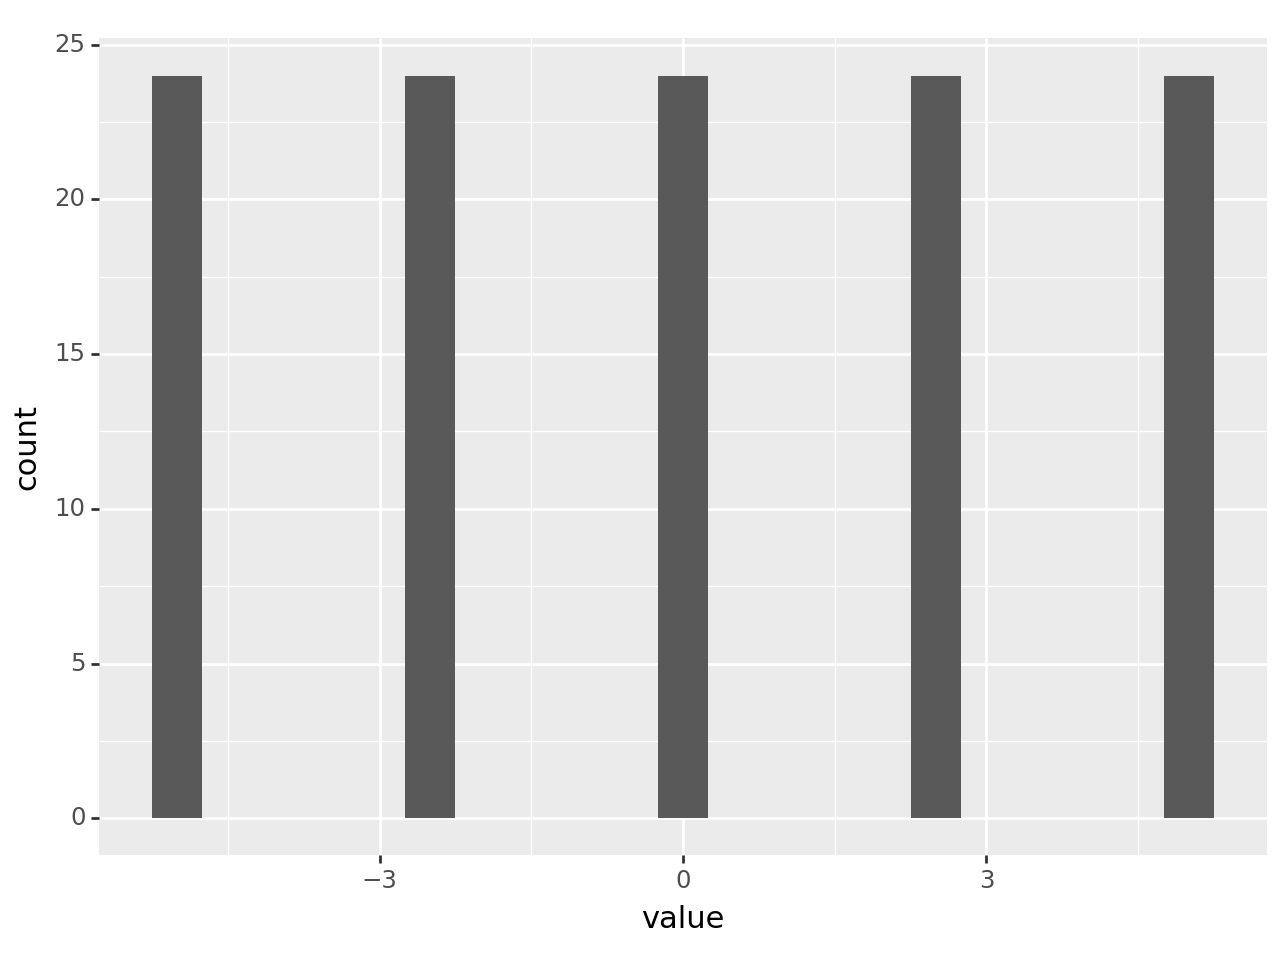

<Figure Size: (640 x 480)>

In [47]:
# pick a random one from the above list
col = "dim13"

(
    ggplot(
        lact_df
            .filter(pl.col("irrep") == "(4, 1)")
            .melt(id_vars=['permutation', 'irrep'])
            .filter(pl.col('variable') == col),
        aes(x='value')
    )
    + geom_histogram(binwidth=0.5)
)


### $S_4$ Cosets via (4, 1)

To properly see that those groups are given by cosets we need to construct the cosets, similar to how we did before. We put the coset info into polars dataframes so that we can use it with the plotting library

In [48]:
from functools import reduce

S4_info = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
        [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
        [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
        [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
        [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
    ]
}


def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, prefix):
    data = []

    for cos in cosets:
        rep = str(cos[0])
        data.extend([
            {'permutation': str(c), f'coset_rep_{prefix}': rep} for c in cos
        ])
    return pl.DataFrame(data)


def make_left_coset_rep_df(subgroups, n):
    data = []

    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i))

    return reduce(_coset_join, data)


def make_right_coset_rep_df(subgroups, n):
    data = []

    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i))

    return reduce(_coset_join, data)


s4_subgroups = [generate_subgroup(gen) for gen in S4_info['generators']]
s4_right_coset_df = make_right_coset_rep_df(s4_subgroups, 5)
s4_left_coset_df = make_left_coset_rep_df(s4_subgroups, 5)

In [49]:
# This is a dataframe where each column represents one of the copies of S4 within
# S5. For each row `permutation` is one of the permutations in S5 and the value in the other
# columns is a coset representative for the coset the permutation is in with respect to that column's
# subgroup
s4_right_coset_df.head()

permutation,coset_rep_0,coset_rep_1,coset_rep_2,coset_rep_3,coset_rep_4
str,str,str,str,str,str
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…"
"""(0, 1, 3, 2, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 3, 2, 4…","""(0, 1, 3, 2, 4…","""(0, 1, 2, 3, 4…"
"""(0, 2, 1, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 2, 1, 3, 4…","""(0, 2, 1, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…"
"""(0, 2, 3, 1, 4…","""(0, 1, 2, 3, 4…","""(0, 2, 1, 3, 4…","""(0, 1, 3, 2, 4…","""(0, 2, 3, 1, 4…","""(0, 1, 2, 3, 4…"
"""(0, 3, 1, 2, 4…","""(0, 1, 2, 3, 4…","""(0, 3, 1, 2, 4…","""(0, 2, 1, 3, 4…","""(0, 1, 3, 2, 4…","""(0, 1, 2, 3, 4…"


It takes a little trial and error to find, but for a dimension like `dim13` that has >95% of its norm focused on a single irrep, it is always clear which subgroup it is aligned with. For `dim13` it's the copy of $S_4$ that fixes 2, and the right cosets of that subgroup, which are organized by which value is in the 2nd position (recall: counting starts from 0). We can see that this is just a different way of looking at the previous histogram.


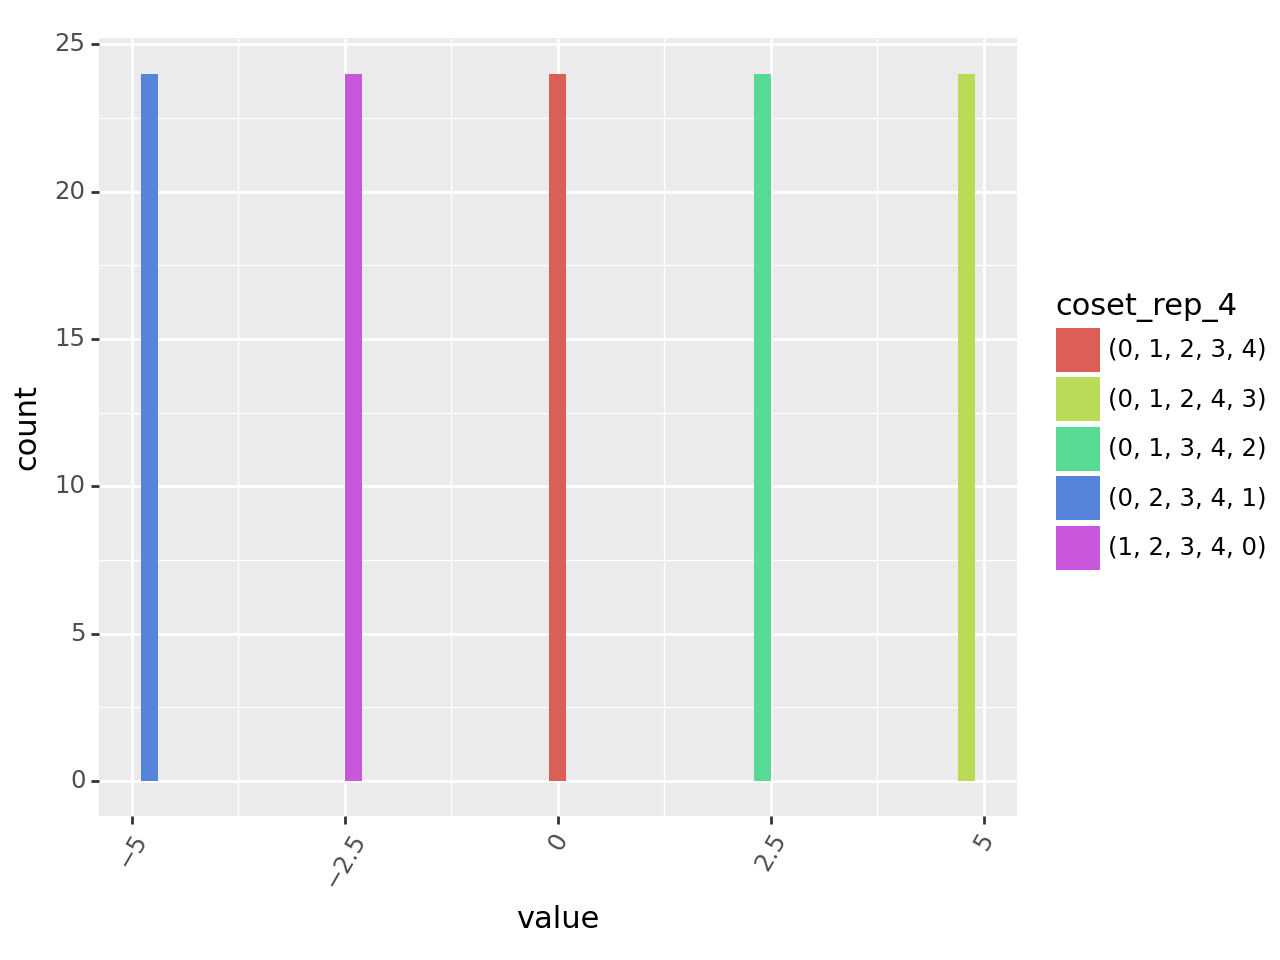

<Figure Size: (640 x 480)>

In [57]:
col = 'dim13'
coset_1 = "coset_rep_4"
df = (
    lact_df.filter(pl.col('irrep') == "(4, 1)")
    .select(['permutation', col])
    .join(s4_right_coset_df.select(['permutation', coset_1]), left_on='permutation', right_on='permutation', how='inner')
    .melt(id_vars=['permutation', coset_1])
)

ggplot(df, aes(x='value', fill=coset_1)) + geom_histogram(binwidth=0.2) + theme(axis_text_x=element_text(rotation=60))

Now let's check the right. The right for `dim13` it's the S4 that fixes 0, and the activations are sorted by the _left_ cosets of S4, which correspond to what position 0 is in.

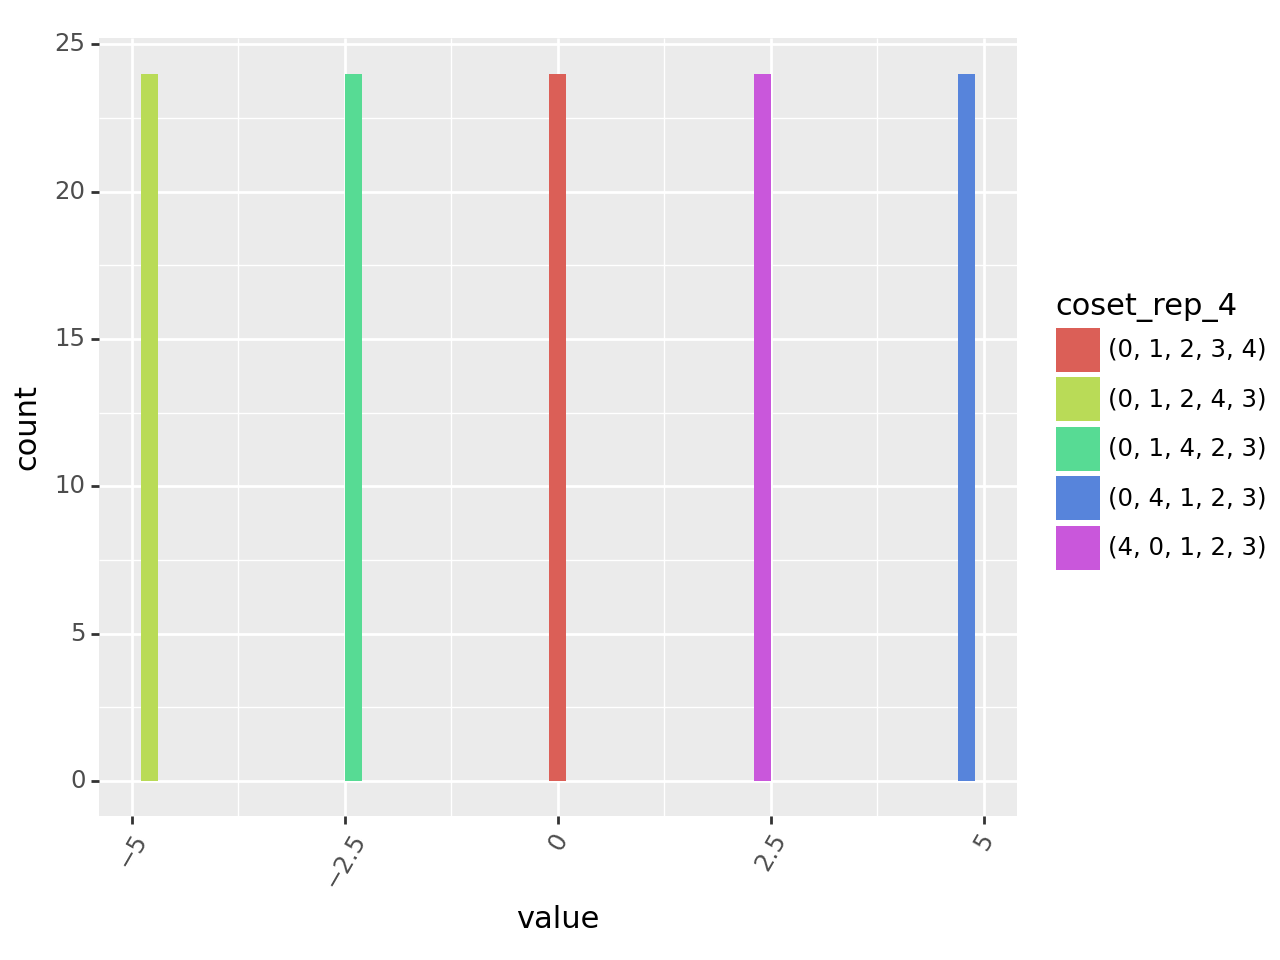

<Figure Size: (640 x 480)>

In [63]:
col = 'dim13'
coset_1 = "coset_rep_4"
df = (
    ract_df.filter(pl.col('irrep') == "(4, 1)")
    .select(['permutation', col])
    .join(s4_left_coset_df.select(['permutation', coset_1]), left_on='permutation', right_on='permutation', how='inner')
    .melt(id_vars=['permutation', coset_1])
)

ggplot(df, aes(x='value', fill=coset_1)) + geom_histogram(binwidth=0.2) + theme(axis_text_x=element_text(rotation=60))

Recall that the linear activations data is each combination of `left_embed + right_embed`.

In [64]:
out, cache = model.run_with_cache(lperms, rperms)

linear_acts = cache['hook_linear']

linear_acts_df = pl.concat(
    [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])],
    how='horizontal'
)
linear_acts_df.head()

permutation_left,permutation_right,permutation_target,index_left,index_right,index_target,in_train,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,…,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,str,str,i64,i64,i64,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",0,0,0,0,0.000045,0.000161,-4.4191e-7,0.000912,-7.247056,-5.254349,2.262256,5.254209,3.764127,-6.884199,-7.062511,6.85609,-0.000003,0.000141,0.817213,-0.000485,7.8366e-20,10.642702,2.263361,12.728447,-9.279509,-10.233256,5.6152e-13,2.261126,4.461925,3.773797,2.9143e-25,-9.287939,-1.4291e-19,5.7550e-9,…,-3.090631,-7.229987,10.480032,0.000689,0.001976,-6.887564,-2.677414,0.000168,-6.263466,0.000231,8.009023,-0.000238,0.000533,3.129076,3.264137,-10.225212,-0.000159,-2.079537,-2.881063,-0.000096,-3.593063,0.000266,-9.282632,0.00024,10.148913,-0.000526,4.455411,1.2747e-23,-2.077289,5.357488,-5.517651,0.000241,-4.949532,-0.787226,6.2948e-22,-2.880378,-1.0365e-25
"""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…","""(0, 1, 3, 4, 2…",0,1,1,0,0.000045,-4.881937,0.001146,0.001374,-4.755307,-5.254542,6.897803,5.254357,3.763767,-6.884317,0.001011,6.856503,-0.000078,-4.885518,-0.000295,-0.000555,-2.1946e-15,7.919165,6.901425,12.728483,-9.279456,-7.614157,-6.8810e-18,4.419665,2.23024,0.000201,4.4065e-25,-9.287823,-1.8977e-19,3.7759e-9,…,-9.42299,-7.229854,10.479465,-2.362624,-3.375367,-6.887637,-2.677557,0.000052,-3.131052,0.00007,5.254973,-0.00023,0.000547,3.129435,3.264331,-7.608195,-0.000175,0.00071,-2.880766,-0.000132,3.766145,0.000143,-9.282633,0.000121,6.817067,4.47174,2.226719,6.2277e-24,0.000686,2.615872,-5.517554,0.00011,-2.416905,0.828375,3.3439e-22,-2.880185,2.8247e-22
"""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…","""(0, 1, 4, 2, 3…",0,2,2,1,0.000045,-2.384145,0.00224,0.001068,-2.376935,-5.254737,4.526051,5.254323,3.76304,-6.8848,-3.612779,6.85713,-0.000031,-2.386021,1.677486,-0.000821,-1.0716e-15,5.320266,4.528496,12.728259,-9.279652,-5.115257,1.1499e-12,-0.000768,6.800065,-3.600601,5.8301e-25,-9.288013,-9.3783e-20,1.8875e-9,…,-6.183133,-7.230267,10.480068,-4.618039,3.539576,-6.888139,-2.677995,0.000041,-9.546483,0.000493,2.62712,-0.000138,0.000693,3.130367,3.264233,-5.111343,-0.000117,-4.258554,-2.880792,-0.000051,0.001254,0.000211,-9.282825,0.000104,13.639809,2.183809,6.790682,-2.7878e-27,-4.253997,-0.0003,-5.51799,0.000159,0.000485,-0.000155,-3.4535e-23,-2.880087,1.3785e-22
"""(0, 1, 2, 3, 4…","""(0, 2, 1, 4, 3…","""(0, 2, 1, 4, 3…",0,3,3,1,-0.000086,-4.881986,0.00224,-10.492558,-2.377013,-5.254617,6.897733,5.254086,3.762565,-6.885141,0.001396,6.857563,-0.000127,-4.885474,0.817814,-0.001349,-2.1947e-15,5.319687,6.901559,3.256425,-2.373408,-5.114518,-1.1492e-12,8.837232,-2.337143,-3.601757,1.4920e-25,-2.375222,-2.8578e-19,1.8878e-9,…,-9.423118,-7.230482,-0.001337,-4.618268,-10.285961,-6.888635,-2.678318,0.00035,3.280971,0.000684,2.627073,-0.000374,0.001143,3.12976,-6.235767,-5.110561,-0.000257,4.257917,5.499771,-0.000188,3.765785,0.000304,-2.373887,0.00037,-0.00117,4.471477,-2.334589,1.8948e-23,4.253241,-0.000749,2.696136,0.000298,0.000263,0.827913,-3.8547e-22,5.498784,7.0310e-22
"""(0, 1, 2, 3, 4…","""(0, 2, 3, 1, 4…","""(0, 2, 3, 1, 4…",0,4,4,1,-0.000132,-0.000115,0.001147,-14.100115,-4.755442,-5.254458,2.26304,5.253917,3.76269,-6.884867,-7.061482,6.85743,-0.000173,-0.000102,1.678213,-0.001401,-1.5276e-19,7.919009,2.264048,-0.000759,0.00081,-7.613763,-1.1492e-12,8.837364,-2.336684,

Recall that anything below zero will get clipped by `relu`

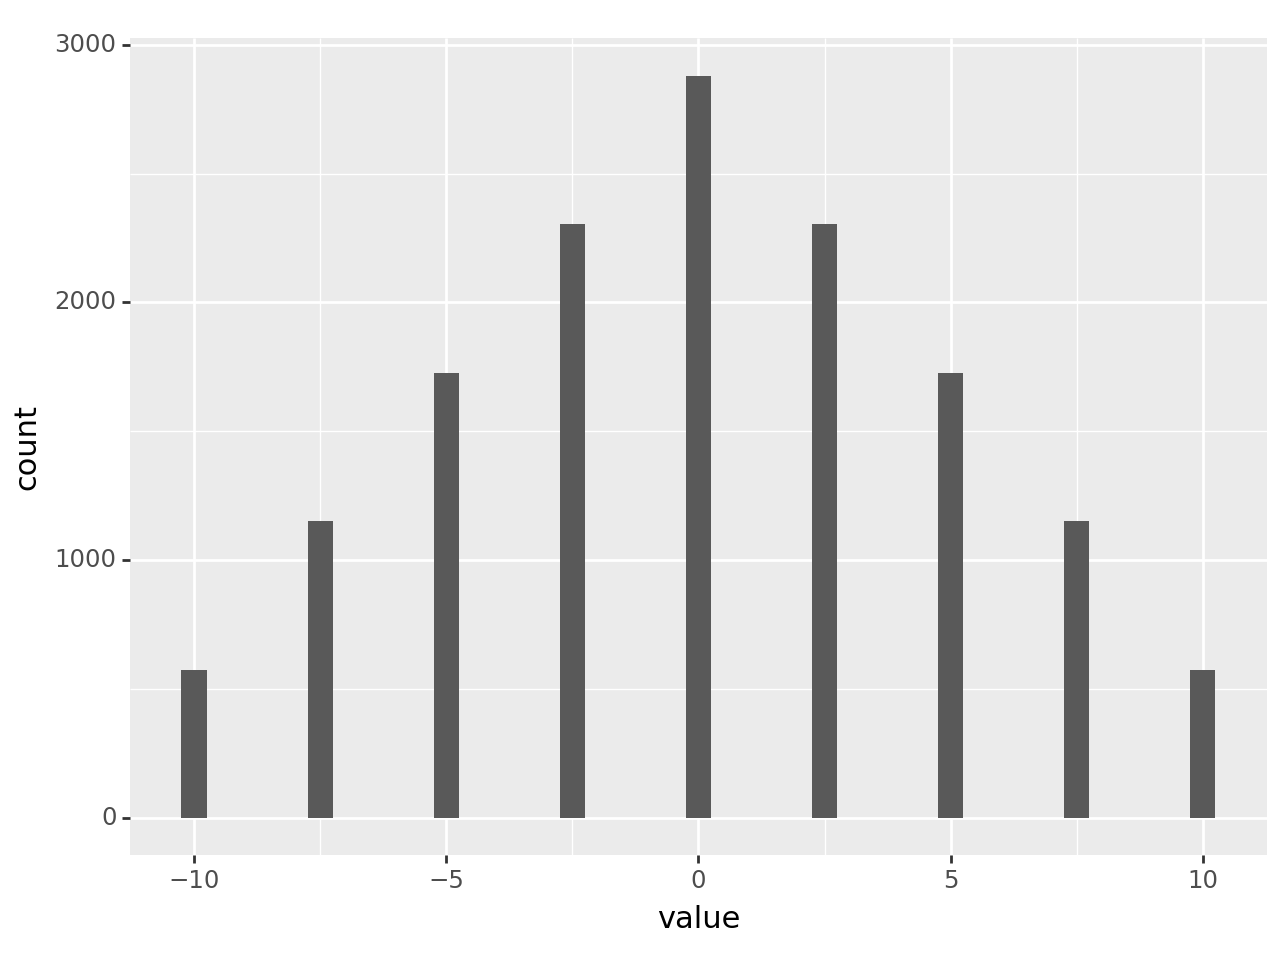

<Figure Size: (640 x 480)>

In [66]:
col = 'dim13'

df = (
    linear_acts_df
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .filter(pl.col('variable') == col)
)

ggplot(df, aes(x='value')) + geom_histogram(binwidth=0.5)


This shows the how the activations break down for the _target_ permutation that the model is trying to predict. If `dim13` fires then the target definitely doesn't have 4 in the 4th (final) position.

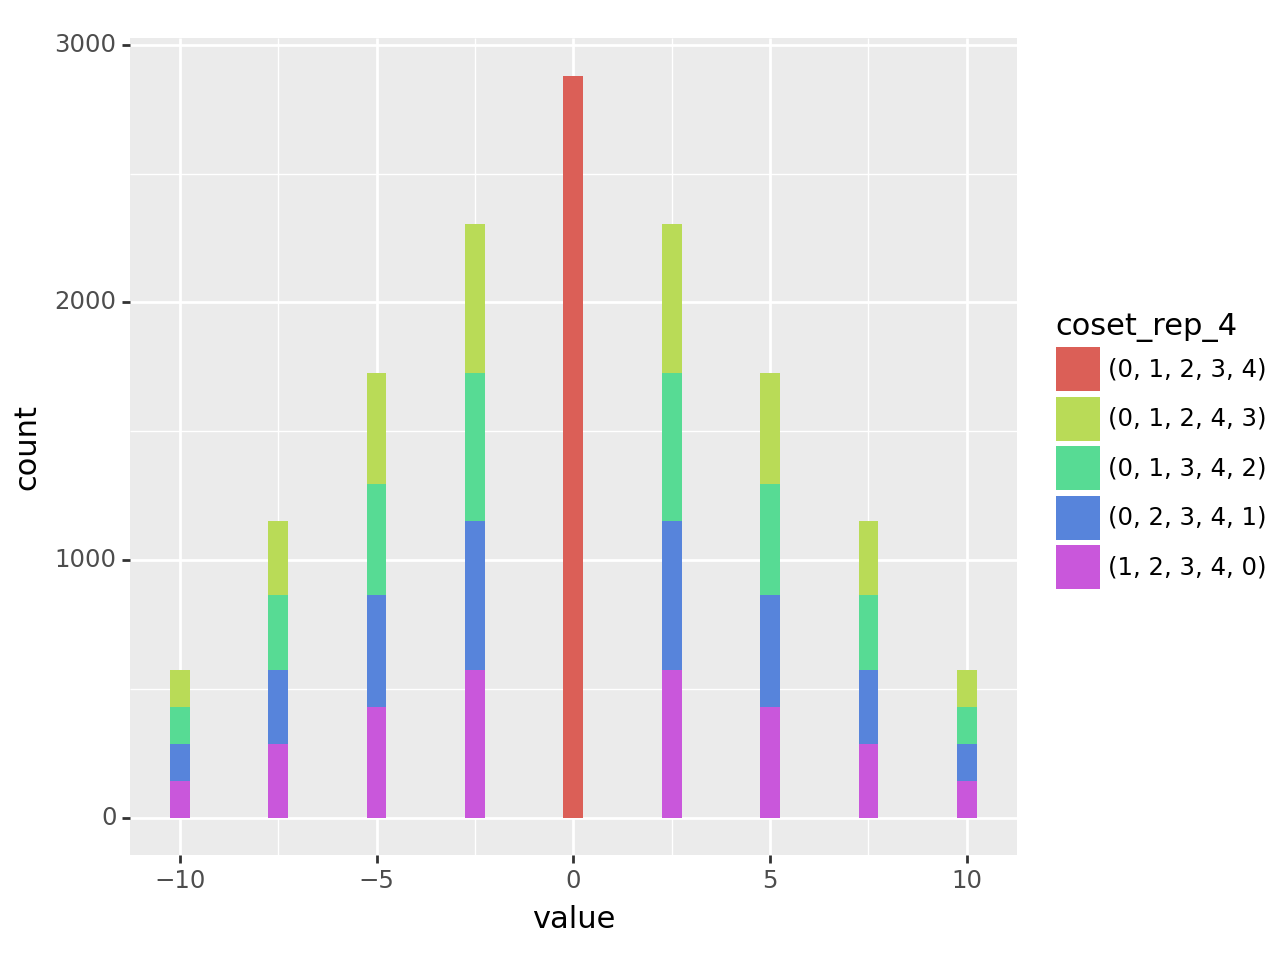

<Figure Size: (640 x 480)>

In [70]:
col = 'dim13'
df = (
    linear_acts_df
    .melt(id_vars=['permutation_left', 'permutation_right', 'permutation_target'])
    .filter(pl.col('variable') == col)
    .join(s4_right_coset_df, left_on='permutation_target', right_on='permutation')
)
#df.head()
ggplot(df, aes(x='value', fill='coset_rep_4')) + geom_histogram(binwidth=0.5)